In [1]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt
h.load_file('stdrun.hoc')

# --- Model: single compartment soma with passive + hh ---
soma = h.Section(name='soma')
soma.L = soma.diam = 20  # µm
soma.Ra = 100
soma.cm = 1.0
soma.insert('pas')
soma.e_pas = -65
soma.g_pas = 1e-4
soma.insert('hh')

# --- Stimulus (we'll change amplitude per trial) ---
stim = h.IClamp(soma(0.5))
stim.delay = 5.0  # ms
stim.dur   = 1.0  # ms

# --- Simulation settings ---
tstop = 40.0  # ms
v_init = -65.0  # mV

# Spike detection threshold (adjustable)
spike_v_threshold = 0.0  # mV; consider -20..0 mV for lower thresholds

# Coarse sweep parameters (nA)
max_amp = 1.0
coarse_step = 0.05
coarse_amps = np.arange(0.0, max_amp + 1e-12, coarse_step)


In [2]:

# Helper: run simulation for a given current amplitude, return time, voltage, and whether it spiked
def run_trial(amp, tstop=tstop, v_init=v_init, detect_v=spike_v_threshold):
    stim.amp = amp
    # fresh recording vectors for this trial
    tvec = h.Vector().record(h._ref_t)
    vvec = h.Vector().record(soma(0.5)._ref_v)
    h.finitialize(v_init)
    h.continuerun(tstop)
    t = np.array(tvec)
    v = np.array(vvec)
    spiked = v.max() > detect_v
    return t, v, spiked

In [3]:
# --- Coarse sweep ---
results = []
for amp in coarse_amps:
    t, v, spiked = run_trial(amp)
    results.append({'amp': amp, 't': t, 'v': v, 'spiked': spiked})

# Find smallest amplitude that caused a spike in coarse sweep
spiking_amps = [r['amp'] for r in results if r['spiked']]
if len(spiking_amps) == 0:
    print("No spikes found up to max_amp = {:.3f} nA. Increase max_amp and retry.".format(max_amp))
    rheobase = None
else:
    first_spike_amp = min(spiking_amps)
    # find largest non-spiking amp below it
    non_spiking_below = [r['amp'] for r in results if (not r['spiked']) and (r['amp'] < first_spike_amp)]
    low = max(non_spiking_below) if non_spiking_below else 0.0
    high = first_spike_amp
    # Bisection refinement between low (no spike) and high (spike)
    tol = 1e-3  # nA resolution
    max_iter = 20
    it = 0
    while (high - low) > tol and it < max_iter:
        mid = 0.5 * (low + high)
        _, _, spiked_mid = run_trial(mid)
        if spiked_mid:
            high = mid
        else:
            low = mid
        it += 1
    rheobase = high
    print("Coarse first spiking amp = {:.3f} nA. Refined rheobase ≈ {:.4f} nA (after {} iterations).".format(first_spike_amp, rheobase, it))

Coarse first spiking amp = 0.100 nA. Refined rheobase ≈ 0.0992 nA (after 6 iterations).


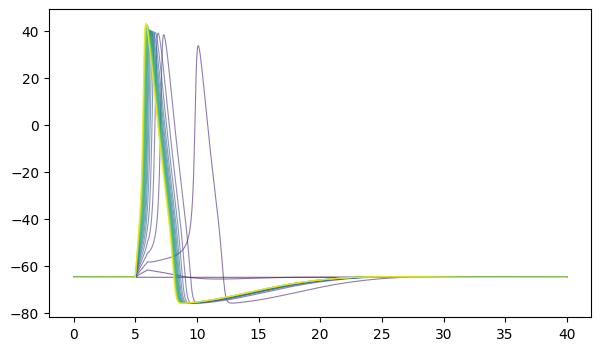

In [4]:
# --- Plot overlayed traces ---
plt.figure(figsize=(7,4))
cmap = plt.get_cmap('viridis')
num = len(results)
for i, r in enumerate(results):
    amp = r['amp']
    t = r['t']; v = r['v']
    color = cmap(i / max(1, num-1))
    lw = 0.8
    alpha = 0.6
    label = None
    # highlight rheobase trace (coarse or refined)
    if rheobase is not None and abs(amp - round(rheobase, 3)) < 1e-6:
        lw = 2.2; alpha = 1.0; color = 'C1'; label = f"{amp:.3f} nA (rheobase, coarse)"
    plt.plot(t, v, color=color, lw=lw, alpha=alpha, label=label)

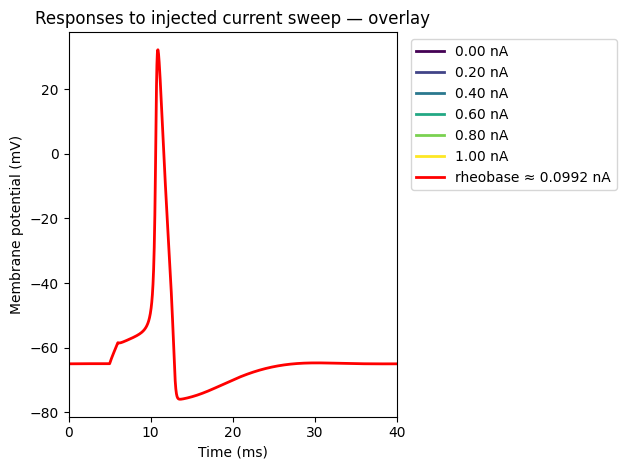

In [5]:
# If rheobase was found by refinement but not exactly in coarse list, plot the refined trace separately
if rheobase is not None and (rheobase not in coarse_amps):
    t_r, v_r, _ = run_trial(rheobase)
    plt.plot(t_r, v_r, color='red', lw=2.0, label=f"{rheobase:.4f} nA (rheobase, refined)")

plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Responses to injected current sweep — overlay')
# create a custom legend: show a couple of example amplitudes for readability
from matplotlib.lines import Line2D
legend_elems = []
# choose up to 6 example amps evenly spaced for legend
example_inds = np.linspace(0, len(coarse_amps)-1, min(6, len(coarse_amps))).astype(int)
for idx in example_inds:
    a = coarse_amps[idx]
    legend_elems.append(Line2D([0],[0], color=cmap(idx / max(1, num-1)), lw=2, label=f"{a:.2f} nA"))
if rheobase is not None:
    legend_elems.append(Line2D([0],[0], color='red', lw=2, label=f"rheobase ≈ {rheobase:.4f} nA"))
plt.legend(handles=legend_elems, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlim(0, tstop)
plt.tight_layout()
plt.show()